In [2]:
using Random
using Random123
using Distributions
using Plots
using StatsPlots
using StatsBase
using Statistics
using DataFrames
using Chain
using Dates
using CSV
include("Utils.jl")

initialize_prngs

In [1]:
# Initializing our relevant arguments
loci = 5 # since the bitwidth of the genome is 128, we can't actually model any arbitrary maximum genome bitsize. what we can do instead is enforce a maximum genome size (effectively, the bitwidth within a UInt128). 
#init_active_loci = 3 # how many loci, out of the total number of loci in the landscape defined above, are unlocked at the start?
max_init_genotype_bits = 1 # makes the initial genotype reproducible between resticted and unlocked landscapes of the same size. max size is the number of init active loci
# what the above lets us model is how the restrictedness of the landscape at initialization (init_active_loci) determines what peaks are reached. max_init_genotype_bits allows
# us to control for the initial genotype when we change the number of unlocked loci at the start, otherwise we would just generate a different starting genotype (potentially one that wasn't available on the restricted landscape)
total_population = 1000
σ_epi::Float64 = 0 # standard deviation of the epistatic effects
μ = (total_population^-1)/10 # Mutation rate of the genotypes with some genome. Claudia says than Nμ = 1 is a weird parameter regime, so we adjust it a bit lower
M = μ#*10^-1 # rate of genome evolution. expansion/streamlining events happen an order of magnitude less, on average, than mutations
simulation_length = 200000


200000

In [3]:
final_genome_sizes = DataFrame(Init_active = Int[], Max_size = Int[], Replicate = Int[], Final_size = Int[], Pos_effects = Int[])
runtime = Dates.format(now(), "yyyymmdd_HH:MM")
for i in 100:133
    print("\r$i")
    for init_active_loci in (1, 3, 5)
        try
            rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i)
            additive_effects = generate_additive_effects(rng_additive, 128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
            df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
            #generate_plots(df_genotypes)
            sweeps = process_data(df_genotypes, μ, M, additive_effects, σ_epi)[7] # assigns only the data from the selective sweep dataframe
            if nrow(sweeps) > 0
                push!(final_genome_sizes, (init_active_loci, loci, i, sum(digits(sweeps[!,:Genome][end], base = 2)), Int(sum(heaviside.(additive_effects[129-loci:end]))))) # genome size of major genotype at end of simulation
                CSV.write("output/additive_landscape_$(runtime).csv", final_genome_sizes)
            else 
                NaN
            end
        catch e
            println("\nError at replicate=$i, init_active_loci=$init_active_loci")
            println(e)
            println(stacktrace(catch_backtrace()))
        end
    end
end

println("Finished at: ", Dates.format(now(), "yyyymmdd_HH:MM"))

Iteration: 200000Finished at: 20250716_11:49


Iteration: 5000

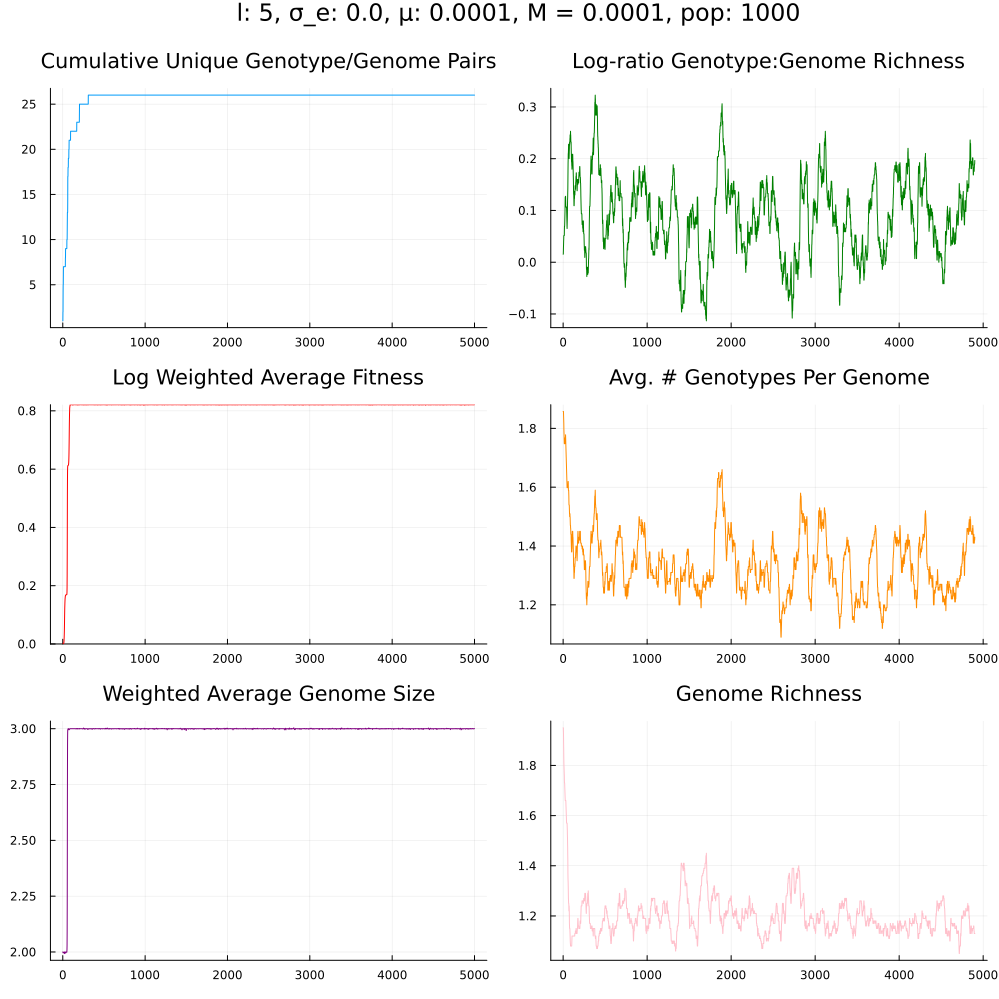

In [3]:
i = 102
init_active_loci = 2
rng_default, rng_additive, rng_init_genotype, rng_init_genome, rng_mutation = initialize_prngs(additive_seed = i)
additive_effects = generate_additive_effects(rng_additive, 128)#zeros(128) # we will always need to generate the full range of additive effects (128 bit)
df_genotypes = simulate(loci, init_active_loci, max_init_genotype_bits, total_population, σ_epi, μ, M, simulation_length, rng_init_genome, rng_init_genotype, rng_default, rng_mutation, additive_effects)
generate_plots(df_genotypes, μ, M, additive_effects, σ_epi)


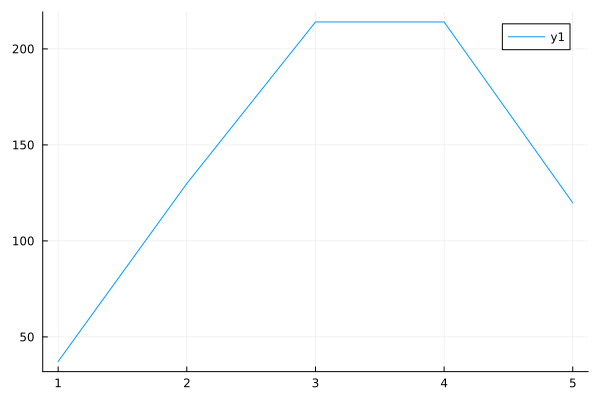

In [17]:
plot(1:5, map(x -> expected_searchtime(x, 5)[1], 1:5))